In [223]:
from email.header import decode_header
import re

import numpy as np
from imap_tools import MailBox
from imap_tools import AND
import pandas as pd
import dateparser
from dateparser.search import search_dates
import string

In [273]:
df = pd.read_csv('files/sorted_df.csv')

In [285]:
df.head()

id                               subject  \
0  82                FWD:Повторная отправка   
1  83       FWD:Re: Шаблон рецензии (новый)   
2  90  FWD:RE: статья Вестник САИТ Рецензия   
3  98     FWD:RE: статья для рецензирования   
4  92            FWD:RE: рецензия на статью   

                                                from  \
0  Павловский Максим Викторович  <pmv-160570@yand...   
1                  Юрий Нечаев  <nechaev_ub@mail.ru>   
2                      Толстобров А.П.  <tap@vsu.ru>   
3            Вялых Сергей Ариевич <vyalyh@govvrn.ru>   
4                      Толстобров А.П.  <tap@vsu.ru>   

                                                text                 date  \
0  Добрый вечер!\r\nОтсылаю материалы рецензии на...  2016-01-14 20:47:03   
1                                    Спасибо.Нечаев.  2018-02-04 19:56:26   
2  Добрый день!\r\nПосылаю рецензию\r\n\r\nС уваж...  2018-02-09 17:36:00   
3  Доброе время суток, Вероника Викторовна!\r\n\r...  2018-02-09 17:54:00   
4  Добрый день!\r\nПосылаю рецензию\r\n\r\nС уваж...  2018-02-11 22:37:00   

                                 attachment_filename  \
0                              Рецензия Гаршиной.doc   
1                                                NaN   
2  Рецензия Толстоброва на статью А.С. Платонова....   
3     рецензия_на_Проблема защита_пользователей.docx   
4  Рецензия Толстоброва на статью Черненькая-Маге...   

                             attachment_content_type  \
0                                 application/msword   
1                                                NaN   
2  application/vnd.openxmlformats-officedocument....   
3  application/vnd.openxmlformats-officedocument....   
4  application/vnd.openxmlformats-officedocument....   

                                             headers  
0  {'dkim-signature': ('v=1; a=rsa-sha256; q=dns/...  
1  {'dkim-signature': ('v=1; a=rsa-sha256; q=dns/...  
2  {'dkim-signature': ('v=1; a=rsa-sha256; q=dns/...  
3  {'dkim-signature': ('v=1; a=rsa-sha256; q=dns/...  
4  {'dkim-signature': ('v=1; a=rsa-sha256; q=dns/...

In [502]:
texts = df[['id','text']]
texts

id                                               text
0       82  Добрый вечер!\r\nОтсылаю материалы рецензии на...
1       83                                    Спасибо.Нечаев.
2       90  Добрый день!\r\nПосылаю рецензию\r\n\r\nС уваж...
3       98  Доброе время суток, Вероника Викторовна!\r\n\r...
4       92  Добрый день!\r\nПосылаю рецензию\r\n\r\nС уваж...
...    ...                                                ...
1132  1065  Высылаю рецензию на материал А.М. Сагдатуллина...
1133  1068  Здравствуйте !\r\nМою отправлен нучную статью ...
1134  1069  Здравствуйте.\nСчитаю, что статья может быть о...
1135  1066  Добрый день, Виктория Викторовна!\r\n\r\nЮрист...
1136   658  Привет друг,\n\n\nЭто Sasa из Тяньцзиня Semri ...

[1137 rows x 2 columns]

In [503]:
texts.dropna(inplace=True)

C:\Users\08642\AppData\Local\Temp\ipykernel_6768\770014963.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  texts.dropna(inplace=True)


In [504]:
texts

id                                               text
0       82  Добрый вечер!\r\nОтсылаю материалы рецензии на...
1       83                                    Спасибо.Нечаев.
2       90  Добрый день!\r\nПосылаю рецензию\r\n\r\nС уваж...
3       98  Доброе время суток, Вероника Викторовна!\r\n\r...
4       92  Добрый день!\r\nПосылаю рецензию\r\n\r\nС уваж...
...    ...                                                ...
1132  1065  Высылаю рецензию на материал А.М. Сагдатуллина...
1133  1068  Здравствуйте !\r\nМою отправлен нучную статью ...
1134  1069  Здравствуйте.\nСчитаю, что статья может быть о...
1135  1066  Добрый день, Виктория Викторовна!\r\n\r\nЮрист...
1136   658  Привет друг,\n\n\nЭто Sasa из Тяньцзиня Semri ...

[977 rows x 2 columns]

## Очистка
Удаляем из текста конструкции с данными вида 
-----Original Message-----
From: Vestnik VSU [mailto:cs-it@cs.vsu.ru] 
Sent: Friday, February 9, 2018 5:36 PM
To: tap@rcnit.vsu.ru
Subject: статья Вестник САИТ
 
И личной подписью вида

С уважением,
Толстобров Александр Павлович
______________________________
mailto: tap@vsu.ru
тел.: +7(473)2555646
моб.тел.: +7-9803424150
Skype: tap-vsu


# Выбираем заголовки сообщения

## Примеры:
1. "-----Original Message-----\r\nFrom: Vestnik VSU [mailto:cs-it@cs.vsu.ru] \r\nSent: Friday, February 9, 2018 5:36 PM\r\nTo: tap@rcnit.vsu.ru\r\nSubject: статья Вестник САИТ\r\n\r\n"
2. "-------- Пересылаемое сообщение --------\n>> От кого: Илья Сандлер < sandleri@bk.ru >\n>> Кому: cs-it < cs-it@cs.vsu.ru >\n>> Дата: Воскресенье,  4 февраля 2018, 12:31 +04:00\n>> Тема: Статья Сандлер И.Л. Комплект документов в журнал " Вестник ВГУ.\n>> Серия: Системный анализ и информационные технологии "\n"
3. "15 февраля 2018 г., 22:11 пользователь Vestnik VSU <cs-it@cs.vsu.ru>\r\nнаписал:\r\n\r\n"
4. "On 19 Feb 2018, at 21:42, Vestnik VSU <cs-it@cs.vsu.ru> wrote:\r\n"
5. "Пятница,  9 февраля 2018, 17:33 +04:00 от Vestnik VSU <cs-it@cs.vsu.ru>:\n" (95)
6. "On Thu, 15 Feb 2018 15:57:32 +0300 \nВладимир Евстафьевич Магер <mv@qmd.spbstu.ru wrote: \n"
7. "15.02.2018, 14:50, "Vestnik VSU" <csit@cs.vsu.ru:"

Удалить
1. Возврат каретки
2. Знаки '>'

In [505]:
test = texts[texts['id']==92]['text']
t = test.values[0]
t

'Добрый день!\r\nПосылаю рецензию\r\n\r\nС уважением,\r\nТолстобров Александр Павлович\r\n______________________________\r\nmailto: tap@vsu.ru\r\nтел.: +7(473)2555646\r\nмоб.тел.: +7-9803424150\r\nSkype: tap-vsu\r\n\r\n\r\n-----Original Message-----\r\nFrom: Vestnik VSU [mailto:cs-it@cs.vsu.ru] \r\nSent: Sunday, February 11, 2018 10:37 PM\r\nTo: tap@vsu.ru\r\nSubject: рецензия на статью\r\n\r\nУважаемый Александр Павлович!\r\nПрошу отрецензировать статью - СИСТЕМА ОН-ЛАЙН ОБЕСПЕЧЕНИЯ КАЧЕСТВА ОБРАЗОВАТЕЛЬНЫХ ПРОГРАММ Л.В. Черненькая, В.Е. Магер Санкт-Петербургский политехнический университет Петра Великого  Гаршина В.В.\r\n'

In [506]:
def remove_re_header(t: str):
    t = re.sub(r'\r+', ' ', t)
    t = re.sub(r'(>+)', '', t)
    t = re.sub(r'\xa0+', ' ', t)
    t = re.sub(r'(\n\s*)+', '\n', t)
    t = re.sub(r'-+', '', t)
    # пример 1
    pattern = r'Пересылаемое сообщение((.*?)(Тема:.*?))\n'
    # пример 2
    pattern2 = r'Original Message((.*?)(Subject:.*?))\n'
    # пример 3
    pattern3 = r'(\n\d{1,2}\s(?:января|февраля|марта|апреля|мая|июня|июля|августа|сентября|октября|ноября|декабря)\s\d{4}\sг\.,\s\d{1,2}:\d{2}.*?пользователь.*?\nнаписал: \n)'
    # пример 4, пример 6
    pattern4 = r'On((.*?)(wrote:.*?))\n'
    # пример 5
    pattern5 = r'(?:Понедельник|Вторник|Среда|Четверг|Пятница|Суббота|Воскресенье).*?:\s'
    # пример 7
    pattern7 = r'\n(\d{1,2}\.\d{2}\.\d{4}, \d{2}:\d{2},.*:\s)'
    t = re.sub(pattern, '', t, flags=re.DOTALL)
    t = re.sub(pattern2, '', t, flags=re.DOTALL)
    t = re.sub(pattern3, '', t)
    t = re.sub(pattern4, '', t, flags=re.DOTALL)
    t = re.sub(pattern5, '', t, flags=re.DOTALL)
    t = re.sub(pattern7, '', t, flags=re.DOTALL)
    return t

In [486]:
def remove_re_headers(texts: list[str]):
    col = []
    for tx in texts:
        new = remove_re_header(str(tx))
        col.append(new)
    return col

In [507]:
texts['text'] = remove_re_headers(texts['text'])
texts

C:\Users\08642\AppData\Local\Temp\ipykernel_6768\3088301438.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  texts['text'] = remove_re_headers(texts['text'])


id                                               text
0       82  Добрый вечер! \nОтсылаю материалы рецензии на ...
1       83                                    Спасибо.Нечаев.
2       90  Добрый день! \nПосылаю рецензию \nС уважением,...
3       98  Доброе время суток, Вероника Викторовна! \nВыс...
4       92  Добрый день! \nПосылаю рецензию \nС уважением,...
...    ...                                                ...
1132  1065  Высылаю рецензию на материал А.М. Сагдатуллина...
1133  1068  Здравствуйте ! \nМою отправлен нучную статью с...
1134  1069  Здравствуйте.\nСчитаю, что статья может быть о...
1135  1066  Добрый день, Виктория Викторовна! \nЮристы оче...
1136   658  Привет друг,\nЭто Sasa из Тяньцзиня Semri Bear...

[977 rows x 2 columns]

In [488]:
def remove_personal_sign(texts):
    col = []
    for t in texts:
        t = str(t)
        pattern_sign = r'(Отв.*?)\n'
        pattern_sign2 = r'С уважением.*?\n'
        t = re.sub(pattern_sign, '', t)
        t = re.sub(pattern_sign2, '', t)
        col.append(t)
    return col

In [508]:
texts['text'] = remove_personal_sign(texts['text'])
texts

C:\Users\08642\AppData\Local\Temp\ipykernel_6768\1538589038.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  texts['text'] = remove_personal_sign(texts['text'])


id                                               text
0       82  Добрый вечер! \nОтсылаю материалы рецензии на ...
1       83                                    Спасибо.Нечаев.
2       90  Добрый день! \nПосылаю рецензию \nТолстобров А...
3       98  Доброе время суток, Вероника Викторовна! \nВыс...
4       92  Добрый день! \nПосылаю рецензию \nТолстобров А...
...    ...                                                ...
1132  1065  Высылаю рецензию на материал А.М. Сагдатуллина...
1133  1068  Здравствуйте ! \nМою отправлен нучную статью с...
1134  1069  Здравствуйте.\nСчитаю, что статья может быть о...
1135  1066  Добрый день, Виктория Викторовна! \nЮристы оче...
1136   658  Привет друг,\nЭто Sasa из Тяньцзиня Semri Bear...

[977 rows x 2 columns]

In [511]:
def remove_mails_urls(texts):
    column = []
    for s in texts:
        s = str(s)
        mail = r'\S+@\S+\.\S+'
        s = re.sub(mail, '', s)
        url = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
        s = re.sub(url, '', s)
        column.append(s)
    return column

In [512]:
texts['text'] = remove_mails_urls(texts['text'])
texts

C:\Users\08642\AppData\Local\Temp\ipykernel_6768\3559435195.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  texts['text'] = remove_mails_urls(texts['text'])


id                                               text
0       82  Добрый вечер! \nОтсылаю материалы рецензии на ...
1       83                                    Спасибо.Нечаев.
2       90  Добрый день! \nПосылаю рецензию \nТолстобров А...
3       98  Доброе время суток, Вероника Викторовна! \nВыс...
4       92  Добрый день! \nПосылаю рецензию \nТолстобров А...
...    ...                                                ...
1132  1065  Высылаю рецензию на материал А.М. Сагдатуллина...
1133  1068  Здравствуйте ! \nМою отправлен нучную статью с...
1134  1069  Здравствуйте.\nСчитаю, что статья может быть о...
1135  1066  Добрый день, Виктория Викторовна! \nЮристы оче...
1136   658  Привет друг,\nЭто Sasa из Тяньцзиня Semri Bear...

[977 rows x 2 columns]

In [513]:
from nltk.corpus import stopwords
stop = stopwords.words('russian')

def clean_text(texts):
    column = []
    texts = texts.apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))
    for s in texts:
               
        s = s.lower()
        s = re.sub(r'[0-9]+', '', s)
        s = re.sub("[" + string.punctuation + "]", " ", s)
        s = re.sub(r'\s+', ' ', s)
        column.append(s)
    return column


In [514]:
texts['text'] = clean_text(texts['text'])
texts

C:\Users\08642\AppData\Local\Temp\ipykernel_6768\1097000192.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  texts['text'] = clean_text(texts['text'])


id                                               text
0       82  добрый вечер отсылаю материалы рецензии работу...
1       83                                    спасибо нечаев 
2       90  добрый день посылаю рецензию толстобров алекса...
3       98  доброе время суток вероника викторовна высылаю...
4       92  добрый день посылаю рецензию толстобров алекса...
...    ...                                                ...
1132  1065  высылаю рецензию материал а м сагдатуллина а б...
1133  1068  здравствуйте мою отправлен нучную статью назва...
1134  1069  здравствуйте считаю статья опубликована журнал...
1135  1066  добрый день виктория викторовна юристы очень с...
1136   658  привет друг это sasa тяньцзиня semri bearings ...

[977 rows x 2 columns]

In [516]:
texts.to_csv('files/cleaned_texts.csv', index=False)

In [517]:
docs = ' '.join(x for x in texts['text'].values)
docs

'добрый вечер отсылаю материалы рецензии работу курсанта если чтото посчитаешь нужным изменить буду за заранее благодарен до свидания  спасибо нечаев  добрый день посылаю рецензию толстобров александр павлович mailto тел моб тел skype tapvsu уважаемый александр павлович просьба отрецензировать статью оптимизация структуры базы данных информационной системы контроля образовательных достижений учащихся а с платонова прикрепляю также новый вариант шаблона рецензии гаршина в в  доброе время суток вероника викторовна высылаю рецензию вложении до связи сергей ариевич добрый день прислали статью журнал проблема защиты пользователей в киберпространстве современный подход к с савина а в поначугин прошу отрецензировать p s статья кажется слабой не научной студенческой соотв уровню журнала прикрепляю новый шаблон рецензии  добрый день посылаю рецензию толстобров александр павлович mailto тел моб тел skype tapvsu уважаемый александр павлович прошу отрецензировать статью система онлайн обеспечения 

In [519]:
rus = set('абвгдеёжзийклмнопрстуфхцчшщъыьэюя ')
conv_text = lambda mas_in : [''.join([j for j in i if j.lower() in rus]) for i in mas_in]


In [520]:
docs = ' '.join([x for x in conv_text(texts['text'].values)])
docs

'добрый вечер отсылаю материалы рецензии работу курсанта если чтото посчитаешь нужным изменить буду за заранее благодарен до свидания  спасибо нечаев  добрый день посылаю рецензию толстобров александр павлович  тел моб тел   уважаемый александр павлович просьба отрецензировать статью оптимизация структуры базы данных информационной системы контроля образовательных достижений учащихся а с платонова прикрепляю также новый вариант шаблона рецензии гаршина в в  доброе время суток вероника викторовна высылаю рецензию вложении до связи сергей ариевич добрый день прислали статью журнал проблема защиты пользователей в киберпространстве современный подход к с савина а в поначугин прошу отрецензировать   статья кажется слабой не научной студенческой соотв уровню журнала прикрепляю новый шаблон рецензии  добрый день посылаю рецензию толстобров александр павлович  тел моб тел   уважаемый александр павлович прошу отрецензировать статью система онлайн обеспечения качества образовательных программ л 

In [521]:
spec_chars = string.punctuation + '«»\t—…’'
# удалить спец символы
docs = "".join([ch for ch in docs if ch not in spec_chars])
# удалить 1 буквенные слова
docs =' '.join([word for word in docs.split() if len(word) > 1])
docs

'добрый вечер отсылаю материалы рецензии работу курсанта если чтото посчитаешь нужным изменить буду за заранее благодарен до свидания спасибо нечаев добрый день посылаю рецензию толстобров александр павлович тел моб тел уважаемый александр павлович просьба отрецензировать статью оптимизация структуры базы данных информационной системы контроля образовательных достижений учащихся платонова прикрепляю также новый вариант шаблона рецензии гаршина доброе время суток вероника викторовна высылаю рецензию вложении до связи сергей ариевич добрый день прислали статью журнал проблема защиты пользователей киберпространстве современный подход савина поначугин прошу отрецензировать статья кажется слабой не научной студенческой соотв уровню журнала прикрепляю новый шаблон рецензии добрый день посылаю рецензию толстобров александр павлович тел моб тел уважаемый александр павлович прошу отрецензировать статью система онлайн обеспечения качества образовательных программ черненькая магер санктпетербургс

In [522]:
from natasha import (
    Segmenter,
    MorphVocab,
    
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    
    PER,
    NamesExtractor,

    Doc
)

In [523]:
segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

names_extractor = NamesExtractor(morph_vocab)

doc = Doc(docs)

In [526]:
doc.segment(segmenter)
doc.tag_morph(morph_tagger)

In [527]:
for token in doc.tokens:
    token.lemmatize(morph_vocab)

In [528]:
print(doc.tokens[:5])

[DocToken(stop=6, text='добрый', pos='ADJ', feats=<Inan,Acc,Pos,Masc,Sing>, lemma='добрый'), DocToken(start=7, stop=12, text='вечер', pos='NOUN', feats=<Inan,Acc,Masc,Sing>, lemma='вечер'), DocToken(start=13, stop=20, text='отсылаю', pos='VERB', feats=<Perf,Masc,Ind,Sing,Past,Fin,Act>, lemma='отсылать'), DocToken(start=21, stop=30, text='материалы', pos='NOUN', feats=<Inan,Acc,Masc,Plur>, lemma='материал'), DocToken(start=31, stop=39, text='рецензии', pos='NOUN', feats=<Inan,Gen,Fem,Sing>, lemma='рецензия')]


In [532]:
docs = ' '.join([_.lemma for _ in doc.tokens])
docs

'добрый вечер отсылать материал рецензия работа курсант если чтотый посчитаешь нужный изменить быть за заранее благодарный до свидание спасибо нечаев добрый день посылать рецензия толстобров александра павлович тело моб тело уважаемый александр павлович просьба отрецензировать статья оптимизация структура база данные информационный система контроль образовательный достижение учиться платонов прикрепляю также новый вариант шаблон рецензия гаршин добрый время сутки вероника викторович высылать рецензия вложение до связь сергей ариевич добрый день прислать статья журнал проблема защита пользователь киберпространство современный подход савин поначугин просить отрецензировать статья казаться слабый не научный студенческий соотв уровень журнал прикреплять новый шаблон рецензия добрый день посылать рецензия толстобров александра павлович тело моб тело уважаемый александр павлович просить отрецензировать статья система онлайн обеспечение качество образовательный программа черненький магера сан

In [301]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\08642\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [299]:
import numpy
from numpy import *
import nltk
import scipy
from nltk.corpus import brown
from nltk.stem import SnowballStemmer
from scipy.spatial.distance import pdist
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
stemmer = SnowballStemmer('russian')

In [533]:
# из библиотеки обработки текста подключаем модуль для токенизации слов
from nltk import word_tokenize
# токенизируем текст
text_tokens = word_tokenize(docs)
# подключаем библиотеку для работы с текстом
import nltk
# переводим токены в текстовый формат
text = nltk.Text(text_tokens)
# подключаем статистику 
from nltk.probability import FreqDist
# и считаем слова в тексте по популярности
fdist = FreqDist(text)
# выводим первые 5 популярных слов
print(fdist.most_common(5))

[('статья', 2000), ('журнал', 1111), ('уважаемый', 748), ('автор', 706), ('научный', 489)]


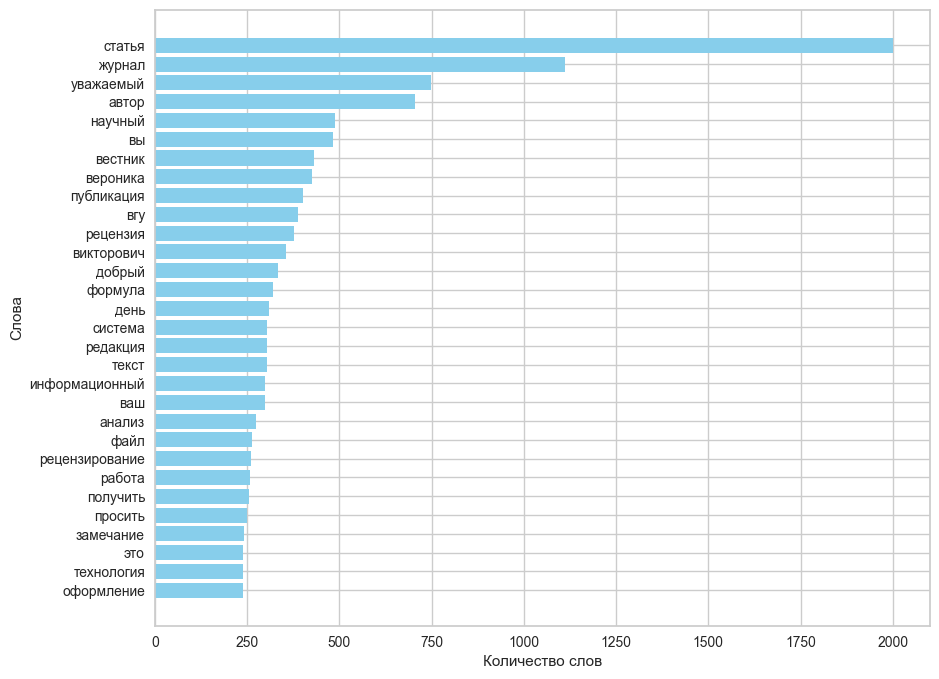

In [539]:
import matplotlib.pyplot as plt

# Получаем самые частые слова и их частоты
most_common_words = fdist.most_common(30)
words = [word[0] for word in most_common_words]
word_counts = [word[1] for word in most_common_words]

# Создаем горизонтальный столбчатый график
plt.figure(figsize=(10, 8))
plt.barh(words, word_counts, color='skyblue')
plt.xlabel('Количество слов')
plt.ylabel('Слова')
plt.gca().invert_yaxis()  # Инвертируем ось y для вывода самых частых слов наверху
plt.show()


In [551]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

In [596]:
stopw = ['статья', 'вероника', 'викторович', 'вестник', 
         'вгу', 'журнал', 'уважаемый', 'автор', 'добрый',
         'научный', 'вы', 'день', 'это'] #массив слов, которые хотим удалить
querywords = docs.split()

resultwords  = [word for word in querywords if word.lower() not in stopw]
docs = ' '.join(resultwords)

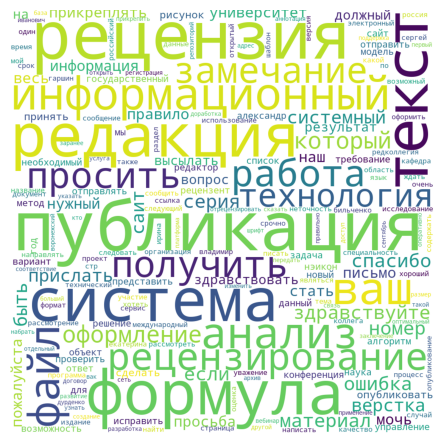

In [597]:

#подадим массив stopw в WordCloud как параметр stopwords
wordcloud = WordCloud(width = 1000, height = 1000, random_state=1, 
                      background_color='white', 
                      collocations=False, stopwords=stopw).generate(docs)
plt.figure()
plt.grid(visible=False)
plt.axis('off')
plt.imshow(wordcloud)

In [562]:
from navec import Navec
path = '../navec_hudlit_v1_12B_500K_300d_100q.tar'
navec = Navec.load(path)

In [ ]:
import torch
from slovnet.model.emb import NavecEmbedding

In [564]:
navec['информационный']

array([ 0.3127614 ,  0.20414656,  0.5651386 ,  0.04223309,  0.14931554,
        0.36725575, -0.02129006,  0.22772074,  0.5048981 ,  0.4191449 ,
       -0.37157744,  0.06837761,  0.3590323 , -0.02047468, -0.10013428,
        0.20835784, -0.07587578, -0.06125216, -0.60878384, -0.02127716,
        0.03297164,  0.31404442, -0.19579253, -0.08221961, -0.00517477,
        0.10368811, -0.1442628 ,  0.5956178 , -0.5669137 ,  0.14679193,
       -0.40885502,  0.2893703 ,  0.3201632 ,  0.09994496,  0.09689018,
        0.08223496,  0.04499295,  0.2609968 , -0.14526236, -0.01147391,
       -0.11642609,  0.3862416 ,  0.45549464,  0.11246306,  0.20145512,
       -0.30739576, -0.1136638 , -0.28105256, -0.34048238,  0.06708384,
       -0.06575659, -0.33591592, -0.05624234, -0.09248733,  0.04750669,
       -0.404882  , -0.03341344, -0.26370022, -0.15970828, -0.35953358,
        0.54654104,  0.42030865, -0.15738703, -0.42234868,  0.24544011,
       -0.03182932, -0.11519814,  0.14297348,  0.21327728, -0.23

In [598]:
prepr_text = Doc(docs)
prepr_text.segment(segmenter)
prepr_text.tag_morph(morph_tagger)

In [599]:
prepr_text.tokens

[DocToken(stop=5, text='вечер', pos='NOUN', feats=<Inan,Acc,Masc,Sing>),
 DocToken(start=6, stop=14, text='отсылать', pos='VERB', feats=<Imp,Inf,Act>),
 DocToken(start=15, stop=23, text='материал', pos='NOUN', feats=<Inan,Acc,Masc,Sing>),
 DocToken(start=24, stop=32, text='рецензия', pos='NOUN', feats=<Inan,Nom,Masc,Sing>),
 DocToken(start=33, stop=39, text='работа', pos='NOUN', feats=<Inan,Nom,Fem,Sing>),
 DocToken(start=40, stop=47, text='курсант', pos='NOUN', feats=<Anim,Nom,Masc,Sing>),
 DocToken(start=48, stop=52, text='если', pos='SCONJ'),
 DocToken(start=53, stop=59, text='чтотый', pos='ADJ', feats=<Nom,Pos,Masc,Sing>),
 DocToken(start=60, stop=70, text='посчитаешь', pos='VERB', feats=<Imp,Ind,Sing,3,Pres,Fin,Act>),
 DocToken(start=71, stop=77, text='нужный', pos='ADJ', feats=<Nom,Pos,Masc,Sing>),
 DocToken(start=78, stop=86, text='изменить', pos='VERB', feats=<Perf,Inf,Act>),
 DocToken(start=87, stop=91, text='быть', pos='AUX', feats=<Imp,Inf,Act>),
 DocToken(start=92, stop=94,

In [582]:
import numpy as np

In [600]:
unk = navec['<unk>']
text_embeddings = []
for token in prepr_text.tokens:
    embedding = navec.get(token.text, unk)
    text_embeddings.append(embedding)

In [587]:
text_embeddings[0]

array([-0.06740946,  0.06183081,  0.13073128,  0.12245024,  0.14599033,
       -0.55641586,  0.15994745,  0.18235211, -0.00638654, -0.67446756,
       -0.07741266,  0.14485441, -0.29826254, -0.13179176,  0.49613556,
        0.04852689,  0.04711103, -0.02781758, -0.05468883, -0.68635845,
        0.03401912, -0.14115255, -0.36587584,  0.45859212,  0.0823245 ,
        0.3985098 ,  0.13661715, -0.48818526, -0.66102254,  0.30158022,
       -0.19193137,  0.04902396,  0.8125157 ,  0.38779584, -0.289814  ,
       -0.07553938, -0.302523  ,  0.03403854,  0.22440016, -0.2605988 ,
       -0.2259032 , -0.5386131 ,  0.34140685, -0.1378421 ,  0.020613  ,
       -0.13972367, -0.21773908,  0.02206516, -0.04929051, -0.3739411 ,
        0.10074051, -0.02373776, -0.09993385,  0.65145254,  0.9066014 ,
       -0.32586125,  0.1637783 , -0.03849501,  0.6298381 ,  0.43476152,
       -0.1469178 , -0.43176702, -0.09634348,  0.09091415,  0.49554163,
        0.37919563, -0.0273017 ,  0.29992107, -0.5110823 , -0.17

In [592]:
len(text_embeddings)

62338

In [593]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [604]:
from sklearn.manifold import TSNE
embeddings = np.array(text_embeddings)
# The default of 1,000 iterations gives fine results, but I'm training for longer just to eke
# out some marginal improvements. NB: This takes almost an hour!
tsne = TSNE(random_state=1, n_iter=250, metric="cosine")

embs = tsne.fit_transform(embeddings)
# Add to dataframe for convenience
df['x'] = embs[:, 0]
df['y'] = embs[:, 1]

ValueError: Length of values (54316) does not match length of index (1137)

In [ ]:
FS = (10, 8)
fig, ax = plt.subplots(figsize=FS)
# Make points translucent so we can visually identify regions with a high density of overlapping points
ax.scatter(df.x, df.y, alpha=.1);

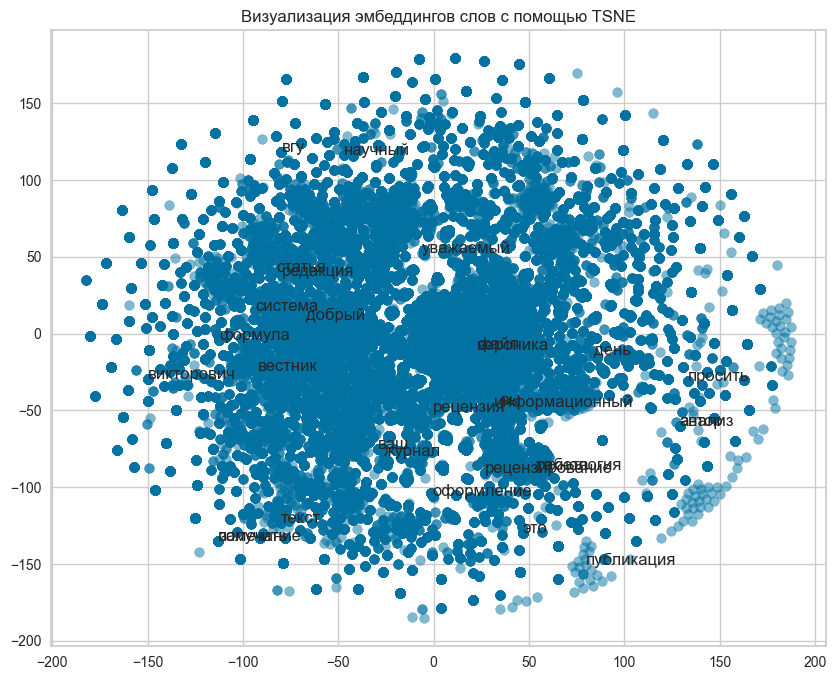

In [605]:
tsne = TSNE(n_components=2, random_state=42)


embeddings_2d = tsne.fit_transform(embeddings)

# Визуализируем полученные 2D эмбеддинги на графике
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5)

# Добавим подписи к точкам (например, слова)
for i, word in enumerate(words):
    plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]))

plt.title('Визуализация эмбеддингов слов с помощью TSNE')
plt.show()